## Burgers Equation - Forward Euler/0-estimation
#### Parameter estimation for Burgers' Equation using Gaussian processes (Forward Euler scheme)


#### Problem Setup

$u_t + u u_{x} = \nu u_{x}$

$u(x,t) = \frac{x}{1+t}$ => We'd expect $\nu = 0$

$u_0(x) := u(x,0) = x$

$x \in [0, 1], t \in \{0, \tau \}$

Using the forward Euler scheme, the equation can be re-written as:

$\frac{u_n - u_{n-1}}{\tau} + u_{n-1} \frac{d}{dx}u_{n-1}  = \nu \frac{d^2}{dx}u_{n-1}$

and setting the factor $u_{n-1} = u_0(x) = x$ (no mean used! Should give a better result) to deal with the non-linearity:

$\tau \nu \frac{d^2}{dx}u_{n-1} - \tau x \frac{d}{dx}u_{n-1} + u_{n-1} = u_{n}$


Consider $u_{n-1}$ to be a Gaussian process.

$u_{n-1} \sim \mathcal{GP}(0, k_{uu}(x_i, x_j, \theta))$

And the linear operator:

$\mathcal{L}_x^\nu = \cdot + \tau \nu \frac{d}{dx}\cdot - \tau x \frac{d}{dx} \cdot$

so that

$\mathcal{L}_x^\nu u_{n-1} = u_n$

Problem at hand: estimate $\nu$ (should be $\nu = 0$ in the end).

For the sake of simplicity, take $u := u_{n-1}$ and $f := u_n$.


#### step 1: Simulate data

Take data points at $t = 0$ for $(u_{n-1})$ and $t = \tau$ for $(u_n)$, where $\tau$ is the time step.

In [1]:
import numpy as np
import sympy as sp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
tau = 0.001
def get_simulated_data(tau):
    x = np.random.rand(50)
    y_u = x
    y_f = x/(1+tau)
    return (x, y_u, y_f)

(x, y_u, y_f) = get_simulated_data(tau)

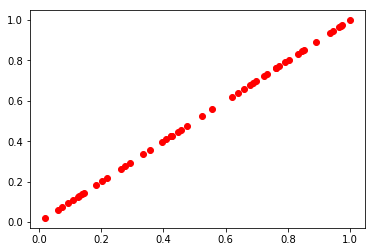

In [3]:
plt.plot(x, y_u, 'ro')
plt.show()

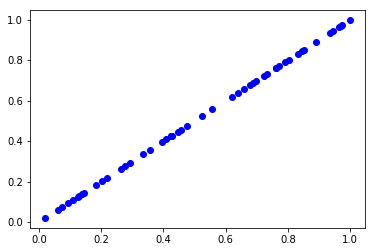

In [4]:
plt.plot(x, y_f, 'bo')
plt.show()

#### Step 2:Evaluate kernels

$k_{nn}(x_i, x_j; \theta) = \theta exp(-\frac{1}{2l}(x_i-x_j)^2)$

In [5]:
x_i, x_j, theta, l, nu = sp.symbols('x_i x_j theta l nu')
kuu_sym = theta*sp.exp(-1/(2*l)*((x_i - x_j)**2))
kuu_fn = sp.lambdify((x_i, x_j, theta, l), kuu_sym, "numpy")
def kuu(x, theta, l):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kuu_fn(x[i], x[j], theta, l)
    return k

$k_{ff}(x_i,x_j;\theta,\phi) \\
= \mathcal{L}_{x_i}^\nu \mathcal{L}_{x_j}^\nu k_{uu}(x_i, x_j; \theta) \\
= k_{uu} + \tau \nu \frac{d}{dx_i}k_{uu} - \tau x_i \frac{d}{dx_i}k_{uu} + \tau \nu \frac{d}{dx_j}k_{uu} + \tau^2 \nu^2 \frac{d}{dx_i} \frac{d}{dx_j}k_{uu} - \tau^2 \nu x_i\frac{d^2}{dx_i dx_j} k_{uu} - \tau x_j \frac{d}{dx_j}k_{uu} - \tau^2 \nu x_j \frac{d^2}{dx_i dx_j} k_{uu} + \tau^2 x_i x_j \frac{d^2}{dx_i dx_j}k_{uu}$

In [6]:
kff_sym = kuu_sym \
        + tau*nu*sp.diff(kuu_sym, x_i) \
        - tau*x_i*sp.diff(kuu_sym, x_i) \
        + tau*nu*sp.diff(kuu_sym, x_j) \
        + tau**2*nu**2*sp.diff(kuu_sym, x_j, x_i) \
        - tau**2*nu*x_i*sp.diff(kuu_sym, x_j, x_i) \
        - tau*x_j*sp.diff(kuu_sym, x_j) \
        - tau**2*nu*x_j*sp.diff(kuu_sym, x_j, x_i) \
        + tau**2*x_i*x_j*sp.diff(kuu_sym, x_j, x_i)
kff_fn = sp.lambdify((x_i, x_j, theta, l, nu), kff_sym, "numpy")
def kff(x, theta, l, nu):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kff_fn(x[i], x[j], theta, l, nu)
    return k

$k_{fu}(x_i,x_j;\theta,\phi) \\
= \mathcal{L}_{x_i}^\nu k_{uu}(x_i, x_j; \theta) \\
= k_{uu} + \tau \nu \frac{d}{dx_i}k_{uu} - \tau x_i\frac{d}{dx_i}k_{uu}$

In [7]:
kfu_sym = kuu_sym + tau*nu*sp.diff(kuu_sym, x_i) - tau*x_i*sp.diff(kuu_sym, x_i)
kfu_fn = sp.lambdify((x_i, x_j, theta, l, nu), kfu_sym, "numpy")
def kfu(x, theta, l, nu):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kfu_fn(x[i], x[j], theta, l, nu)
    return k

In [8]:
def kuf(x, theta, l, nu):
    return kfu(x,theta, l, nu).T

#### Step 3: Compute NLML

In [9]:
def nlml(params, x, y1, y2, s):
    theta_exp = np.exp(params[0]) 
    l_exp = np.exp(params[1])
    K = np.block([
        [kuu(x, theta_exp, l_exp) + s*np.identity(x.size), kuf(x, theta_exp, l_exp, params[2])],
        [kfu(x, theta_exp, l_exp, params[2]), kff(x, theta_exp, l_exp, params[2]) + s*np.identity(x.size)]
    ])
    y = np.concatenate((y1, y2))
    val = 0.5*(np.log(abs(np.linalg.det(K))) + np.mat(y) * np.linalg.inv(K) * np.mat(y).T)
    return val.item(0)

#### Step 4: Optimise hyperparameters

In [10]:
m = minimize(nlml, np.random.rand(3), args=(x, y_u, y_f, 1e-3), method="Nelder-Mead", options = {'maxiter' : 1000})

In [11]:
m.x[2]

-0.0014204185086372787

In [12]:
m

 final_simplex: (array([[ 1.79455786e+00,  2.81548994e+00, -1.42041851e-03],
       [ 1.79452433e+00,  2.81544663e+00, -1.37456407e-03],
       [ 1.79453626e+00,  2.81546952e+00, -1.45628472e-03],
       [ 1.79451643e+00,  2.81545305e+00, -1.36577737e-03]]), array([-332.30141161, -332.30141161, -332.30141161, -332.30141161]))
           fun: -332.3014116103712
       message: 'Optimization terminated successfully.'
          nfev: 257
           nit: 144
        status: 0
       success: True
             x: array([ 1.79455786e+00,  2.81548994e+00, -1.42041851e-03])